#  Fibroblast trajectory using scvelo and cellrank

In [2]:
import sys
import subprocess

%matplotlib inline
import re
import glob
import os
import sys

import scanpy as sc
import scvelo as scv
import cellrank as cr
import scvi
import numpy as np
import pandas as pd
import pickle as pkl#
import scipy
import sklearn #

import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)

from numpy import cov
from collections import Counter
from collections import defaultdict
from collections.abc import Iterable
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from matplotlib import rcParams

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

rcParams['figure.figsize'] = 20,20

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

import torch
print('cuda availability : {}'.format(torch.cuda.is_available()))
print('cuda count : {}'.format(torch.cuda.device_count()))
print(torch.version.cuda)

Global seed set to 0


cuda availability : False
cuda count : 0
11.7


# Prepare data

In [19]:
# obj paths
 
data = {

'fski_qc_norm_scvi':'/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/A1_V1_FS_new_Gene_norm_qc_sliced_scvi.h5ad',
'fski_velocyto':'/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/FS_new_Velocyto_raw_combined_processedsize.h5ad',
}

In [3]:
# Palantir object
adata = sc.read('nfs/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/Fibro_dpt_palantir_pseudotime_estimated.h5ad')


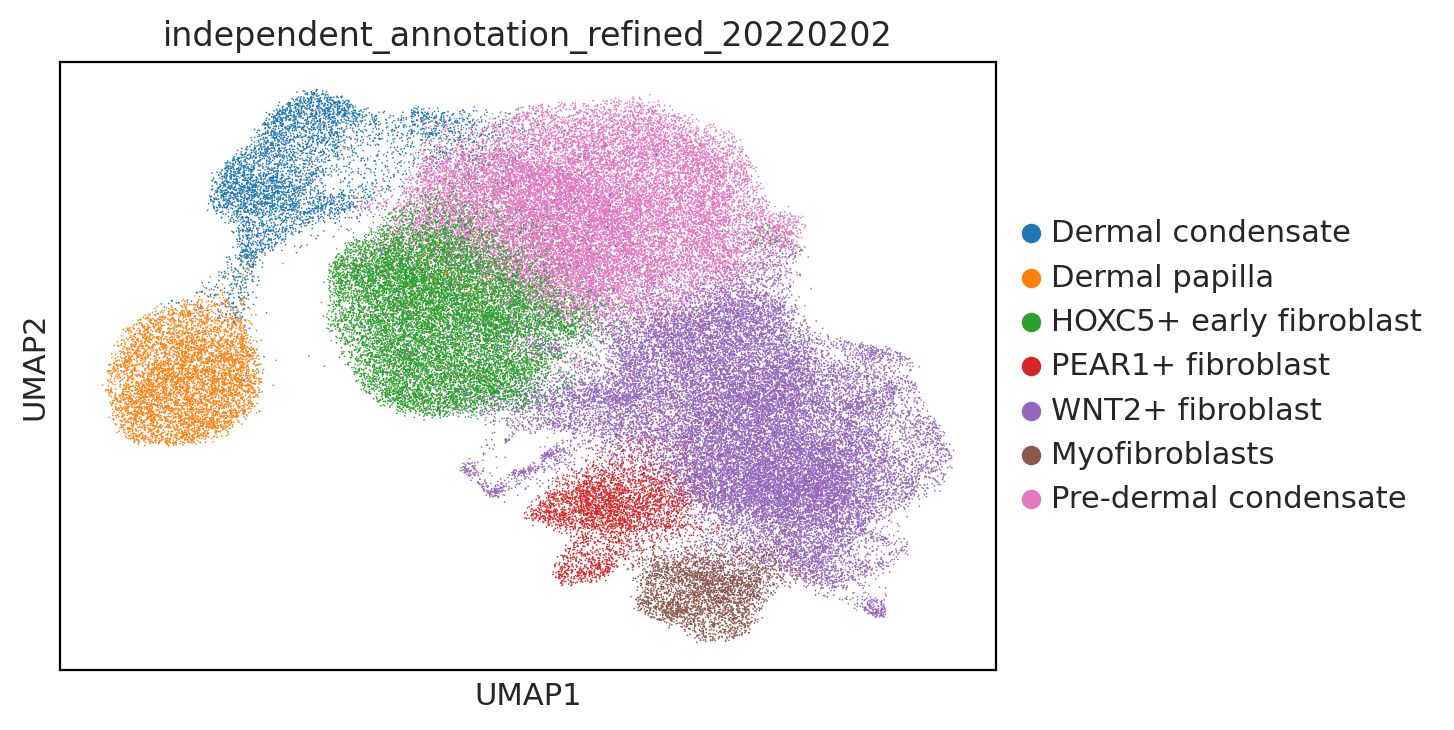

index
ACACCCTGTCGTTGTA-1-4834STDY7002879    WNT2+ fibroblast
ACTGTCCGTAGCGATG-1-4834STDY7002879    WNT2+ fibroblast
AGCGGTCAGCTTCGCG-1-4834STDY7002879    WNT2+ fibroblast
AGTGAGGCAAAGTGCG-1-4834STDY7002879    WNT2+ fibroblast
ATAACGCGTACCGGCT-1-4834STDY7002879    WNT2+ fibroblast
                                            ...       
TTAGTTCTCTGCGGCA-1-FCAImmP7964510       Dermal papilla
TTCGAAGCATGGTAGG-1-FCAImmP7964510       Dermal papilla
TTCTCCTTCATATCGG-1-FCAImmP7964510       Dermal papilla
TTGCGTCCATCCTAGA-1-FCAImmP7964510       Dermal papilla
TTTACTGGTTAAAGTG-1-FCAImmP7964510     WNT2+ fibroblast
Name: independent_annotation_refined_20220202, Length: 84699, dtype: category
Categories (7, object): ['Dermal condensate', 'Dermal papilla', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'WNT2+ fibroblast', 'Myofibroblasts', 'Pre-dermal condensate']

In [4]:
# Have a look at the object
sc.pl.umap(adata, color='independent_annotation_refined_20220202')

# How are the populations called in this object?
adata.obs['independent_annotation_refined_20220202']

In [18]:
#  script to load the data in
def load_adatas(adatas_dict,data_merge, data_key_use,QC_normalise,backed=None):
    if data_merge == True:
        # Read
        gene_intersect = {} # unused here
        adatas = {}
        for dataset in adatas_dict.keys():
            if 'https' in adatas_dict[dataset]:
                print('Loading anndata from web source')
            adatas[dataset] = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[dataset])
            print('Loading anndata {} from local source'.format(dataset))
            if backed == 'r':
                print('Loading data in backed mode! To move into memory run .to_memory()')
            adatas[dataset] = sc.read(adatas_dict[dataset],backed)
            adatas[dataset].var_names_make_unique()
            adatas[dataset].obs['dataset_merge'] = dataset
            adatas[dataset].obs['dataset_merge'] = dataset
#             adatas[dataset].obs.index = adatas[dataset].obs.index + dataset
            gene_intersect[dataset] = list(adatas[dataset].var.index)
            print('All datasets successfully read into a dictionary')
        print('Attempting to collapse dictionary into single joint concatenation')
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner',index_unique=None) # consider only genes that are intersecting
        return adatas, adata
    elif data_merge == False:
        if 'https' in adatas_dict[data_key_use]:
            print('Loading anndata from web source')
            adata = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[data_key_use])
        else: 
            print('Loading anndata {} from local source'.format(data_key_use))
            if backed == 'r':
                print('Loading data in backed mode! To move into memory run .to_memory()')
            adata = sc.read(adatas_dict[data_key_use],backed)
    if QC_normalise == True:
        print('option to apply standardisation to data detected, performing basic QC filtering')
        print('Warning we have not implemented a norm check here, so we assume your inut here is raw!')
        adata.raw = adata[:]
        print('Anndata shape is {}'.format(adata.shape))
        #sc.pp.filter_cells(adata, min_genes=200) # No cell filters heren as we want the same [0] dimension as previous analyses
        #sc.pp.filter_genes(adata, min_cells=10) # 
        print('QC filtered Anndata shape is {}'.format(adata.shape))
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        sc.pp.log1p(adata)
    return adata


Loading anndata fski_qc_norm_scvi from local source
Loading data in backed mode! To move into memory run .to_memory()
Loading anndata fski_velocyto from local source
Loading data in backed mode! To move into memory run .to_memory()


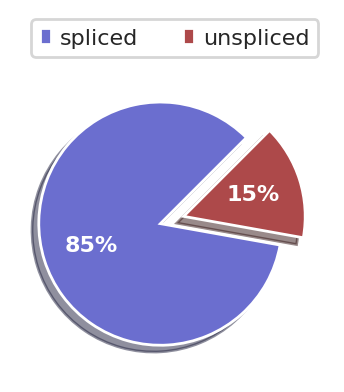

In [20]:
# Addition of data keys and exclusion of all populations that are not relevant here
data_key_use = 'fski_qc_norm_scvi'
velo_data = 'fski_velocyto'
var_key = 'independent_annotation_refined_20220202'
subset_keys = ['Dermal condensate', 'Dermal papilla', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'WNT2+ fibroblast','PEAR1+ fibroblast','Myofibroblasts'] #'FRZB+ fibroblast'
adata_r = load_adatas(data,data_merge = False, data_key_use = data_key_use, QC_normalise = False,backed='r')
adata = adata_r[adata_r.obs[var_key].isin(subset_keys)].to_memory()
adata_vr = load_adatas(data,data_merge = False, data_key_use = velo_data, QC_normalise = False,backed='r')
adata_v = adata_vr[adata_vr.obs.index.isin(adata.obs.index)].to_memory()
scv.pl.proportions(adata_v)
adata_v

adata_v
var_name = var_key




In [17]:
var_key = 'independent_annotation_refined_20220202'

integrate = False
lin_vae = False
batches = ['chemistry_sorting','donor', 'gender', 'cell_caller']
labels_key = var_key
var_name =var_key

In [22]:
colors_fibroblast=['#7D88BA', '#C0C2D6', '#BC7784', '#E6C1AB', '#8895CB', '#EAD3CB','#2EB8C9']

colors = colors_fibroblast

In [23]:
outlier_detection_removal = True
adata.uns[var_name+'_colors'] = colors

In [10]:
# Look at cell number to see how long it will take
adata_v

AnnData object with n_obs × n_vars = 84699 × 36601
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'age'
    var: 'gene_ids', 'feature_types'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [24]:
# Integrate  object with splicing information
def scvi_integrate_time(adata,lin_vae,batches,labels_key ):
    if lin_vae == True:
        arches_params = dict(
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
        n_hidden=128)

        scvi.model.LinearSCVI.setup_anndata(
        adata,
        labels_key = 'annot',
        layer=None,
        batch_key='lr_batch')

        vae = scvi.model.LinearSCVI(adata, n_latent=20, **arches_params)
        #vae = scvi.model.SCVI(adata, n_latent=30,n_hidden=256, **arches_params)
        vae.train(early_stopping=True,
            train_size=0.2,
            early_stopping_patience=45,
            max_epochs=250, 
            batch_size=1024, 
            limit_train_batches=10#,use_gpu=True
           )
        X_scvi = vae.get_latent_representation()
        X_loading = vae.get_loadings()
        adata.obsm['X_scvi'] = X_scvi
        adata.varm['X_scvi'] = X_loading
    else:
        scvi.model.SCVI.setup_anndata(
        adata,
        layer=None,
        categorical_covariate_keys = batches,
        )
        arches_params = dict(
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
        n_hidden=256
        )
        vae = scvi.model.SCVI(adata, n_latent=20,**arches_params)
        vae.train(early_stopping=True,
                train_size=0.5,
                early_stopping_patience=45,
                max_epochs=250, 
                batch_size=1024, 
                limit_train_batches=10#,use_gpu=True
               )
        X_scvi = vae.get_latent_representation()
        adata.obsm['X_scvi'] = X_scvi
        return adata


In [25]:
adata_v = scvi_integrate_time(adata_v,lin_vae,batches,labels_key)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 250/250: 100%|██████████| 250/250 [8:13:39<00:00, 114.98s/it, loss=6.63e+03, v_num=1]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [8:13:39<00:00, 118.48s/it, loss=6.63e+03, v_num=1]


In [26]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/scvelo_fibro_a5.h5ad"
adata_v.write(filename, compression="lzf")

# Start with velocity analysis

In [39]:
# adata_v = adata_v[:,adata.var.index]
scv.pp.filter_genes(adata_v, min_shared_counts=20)
scv.pp.normalize_per_cell(adata_v)
scv.pp.filter_genes_dispersion(adata_v, n_top_genes=10000)
scv.pp.log1p(adata_v)

Filtered out 23980 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 10000 highly variable genes.


/tmp/ipykernel_251/3258196454.py:5: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata_v)


In [40]:
# Copy  object and velocity object together
# move graph
partitions = {
'obsm': adata.obsm,
'obs':adata.obs,
'obsp':adata.obsp,
'uns':adata.uns,
}
for partition_key in partitions:
    # this automtically loads the slice into memory, else use the .to_memory() function
    setattr(adata_v,partition_key,partitions[partition_key]) 
adata = adata_v.copy()

In [41]:
kernel = 'scv'#CTK #None defaults to just scVELO
outlier_lambda = -1 # (-) negative values lower the threshold by x*std around the mean of the cluster centeroid
outlier_embedding = 'scvi'
use_smoothing_kernel = True
smoothing_kernel = 'CTK' #or connectivity
basis = 'umap'
ck_weight = 0.3
i_ck_weight = 0.7

In [44]:
print('Computing First and second order splicing dynamics')
scv.pp.moments(adata, use_rep = 'X_scvi', n_pcs=10, n_neighbors=30)# Compute first and second order moments for each cell using the SCVI neighbor graph


Computing First and second order splicing dynamics
computing neighbors
    finished (0:00:17) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:01:21) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [52]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:01:36) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/26 cores)


/home/jovyan/my-conda-envs/clone_20230628_cellrank/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:437: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/84699 [00:00<?, ?cells/s]

    finished (0:18:56) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:33) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


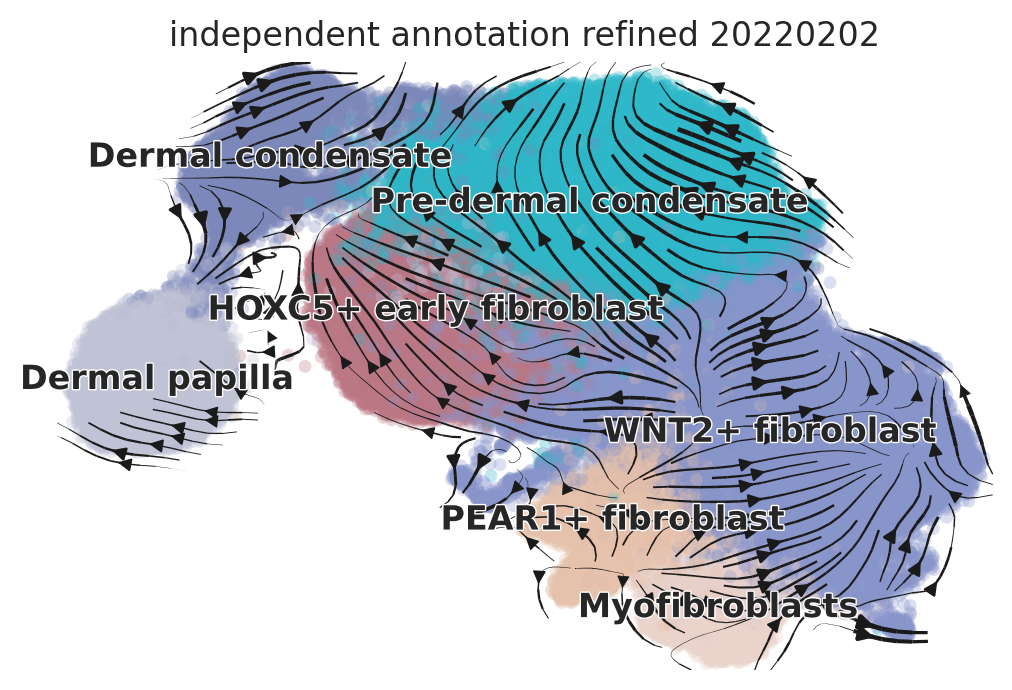

In [53]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=var_name)

In [54]:
print('Computing scv transition matrix representation and embeddings')
from cellrank.kernels import VelocityKernel
scv.tl.recover_dynamics(adata) #, n_jobs=-1
scv.tl.velocity(adata)


Computing scv transition matrix representation and embeddings
recovering dynamics (using 1/26 cores)


/home/jovyan/my-conda-envs/clone_20230628_cellrank/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:437: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1736 [00:00<?, ?gene/s]

    finished (3:41:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:01:33) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [55]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/scvelo_fibro_c5.h5ad"
adata.write(filename, compression="lzf")

# Add cellrank kernels

In [5]:
from cellrank.kernels import PseudotimeKernel
pk = PseudotimeKernel(adata, time_key='palantir_pseudotime')
pk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)


from cellrank.kernels import VelocityKernel
vk = VelocityKernel(adata)
vk.compute_transition_matrix()


Computing transition matrix based on pseudotime


  0%|          | 0/84699 [00:00<?, ?cell/s]

    Finish (0:01:03)
Computing transition matrix using `'deterministic'` model


  0%|          | 0/84699 [00:00<?, ?cell/s]

Using `softmax_scale=15.3295`


  0%|          | 0/84699 [00:00<?, ?cell/s]

    Finish (0:08:45)


VelocityKernel[n=84699, model='deterministic', similarity='correlation', softmax_scale=15.33]

Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:53)


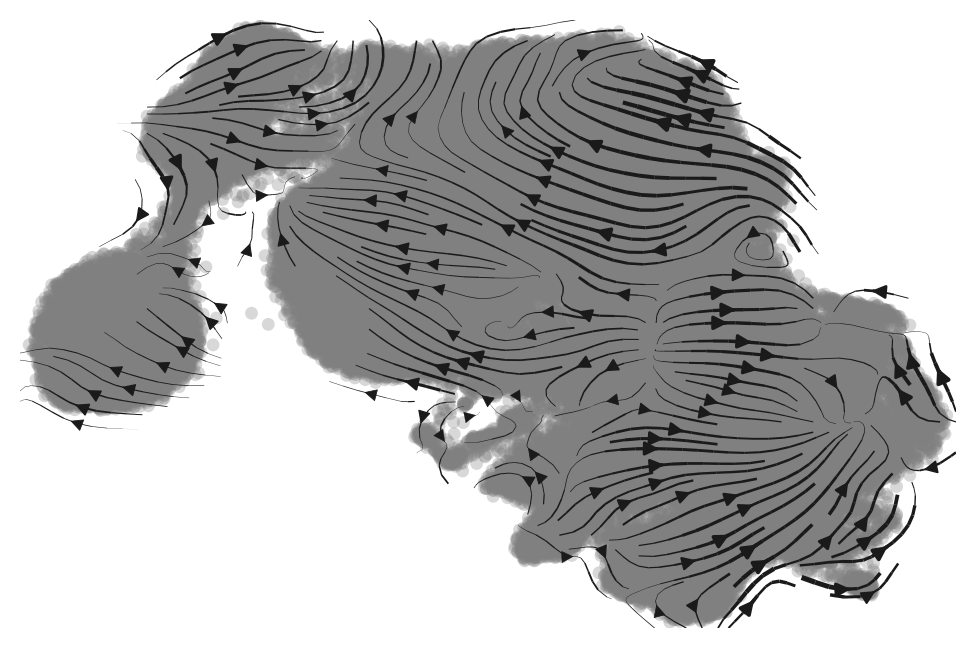

Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_4_umap']`
    Finish (0:00:52)


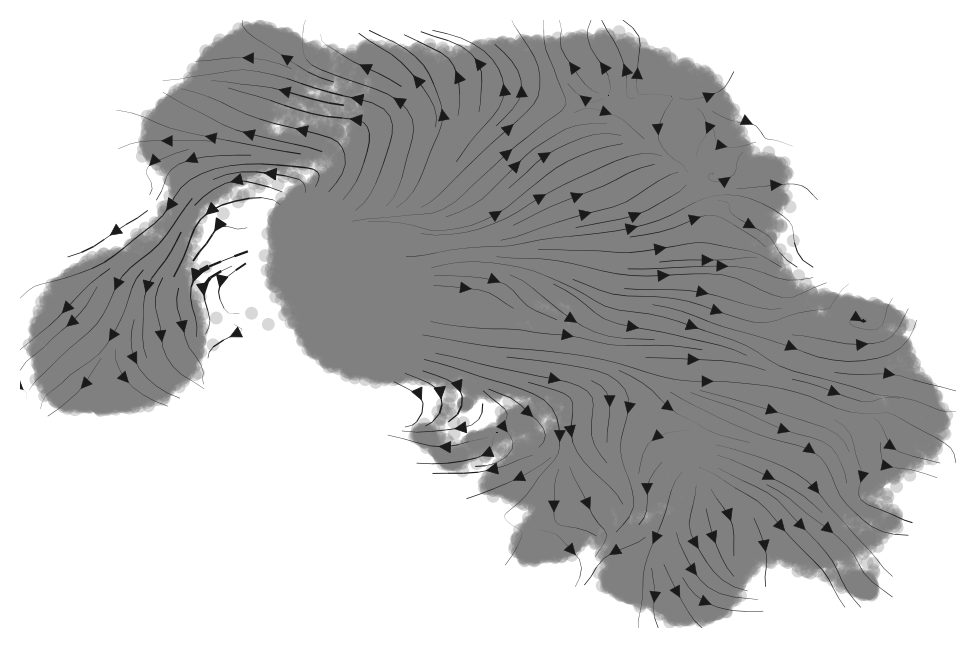

In [62]:
vk.plot_projection(basis="umap", key_added='T_fwd')
pk.plot_projection(basis="umap", key_added='T_fwd_4')


In [57]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/scvelo_fibro_d5.h5ad"
adata.write(filename, compression="lzf")

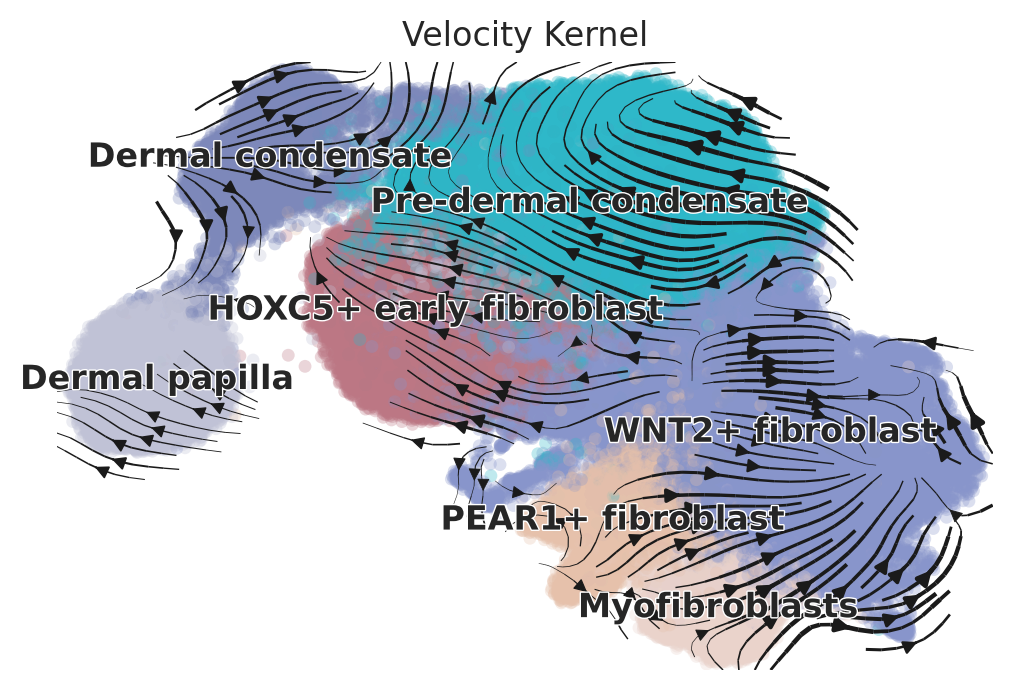

In [63]:
#Plot umaps
scv.pl.velocity_embedding_stream(adata, color=var_name,basis="umap",vkey="T_fwd", legend_fontsize=12, title="Velocity Kernel", smooth=0.8, min_mass=3)


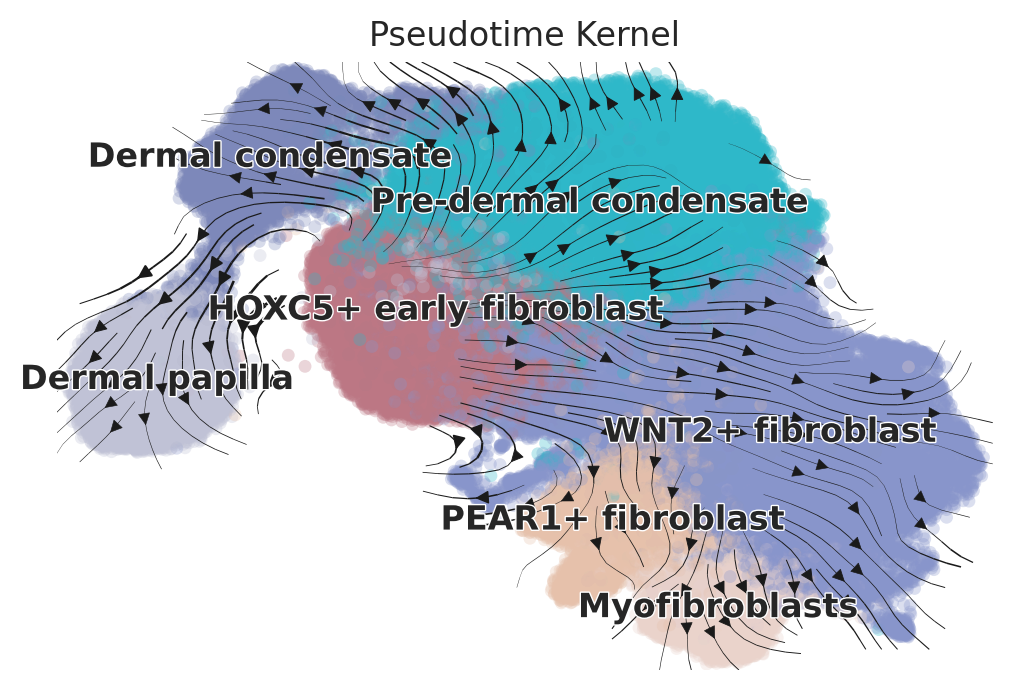

In [65]:
scv.pl.velocity_embedding_stream(adata, color=var_name,basis="umap",vkey="T_fwd_4", legend_fontsize=12, title= "Pseudotime Kernel", smooth=0.8, min_mass=3)


In [7]:
kernel = 'scv'#CTK #None defaults to just scVELO
outlier_lambda = -1 # (-) negative values lower the threshold by x*std around the mean of the cluster centeroid
outlier_embedding = 'scvi'
use_smoothing_kernel = True
smoothing_kernel = 'CTK' #or connectivity
basis = 'umap'
first_weight = 0.3
second_weight = 0.7
third_weight = 0.5

In [8]:
combined_kernel4 = second_weight * vk + first_weight * pk
combined_kernel5 = third_weight * vk + third_weight * pk
combined_kernel6 = first_weight * vk + second_weight * pk

In [9]:
w_ck = vk.copy()

Using precomputed projection `adata.obsm['T_fwd_wck5_umap']`


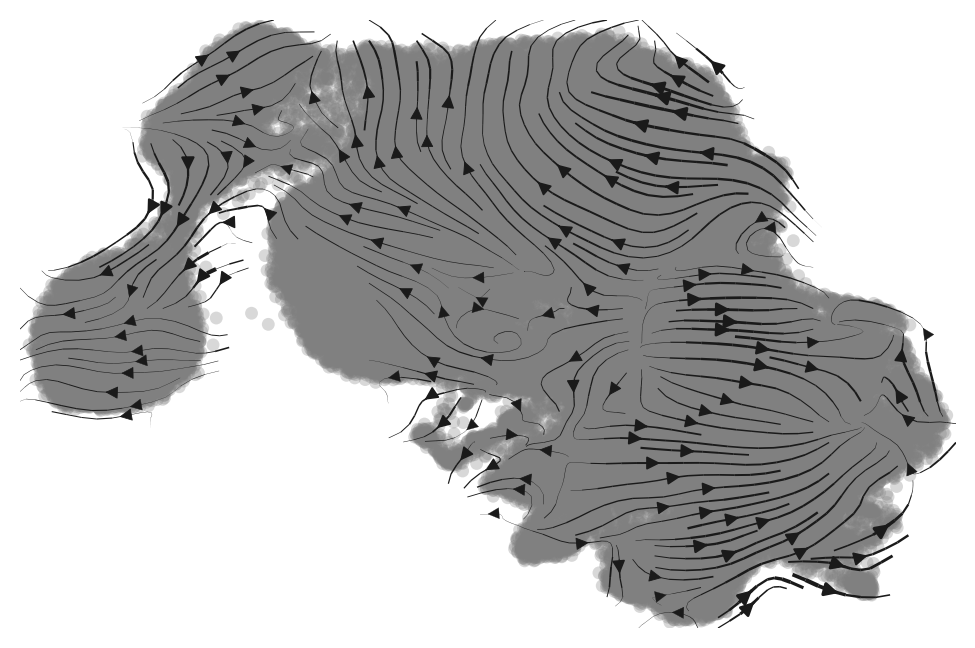

In [10]:
w_ck.transition_matrix = combined_kernel5.transition_matrix
w_ck.plot_projection(basis="umap", key_added='T_fwd_wck5')

Using precomputed projection `adata.obsm['T_fwd_wck6_umap']`


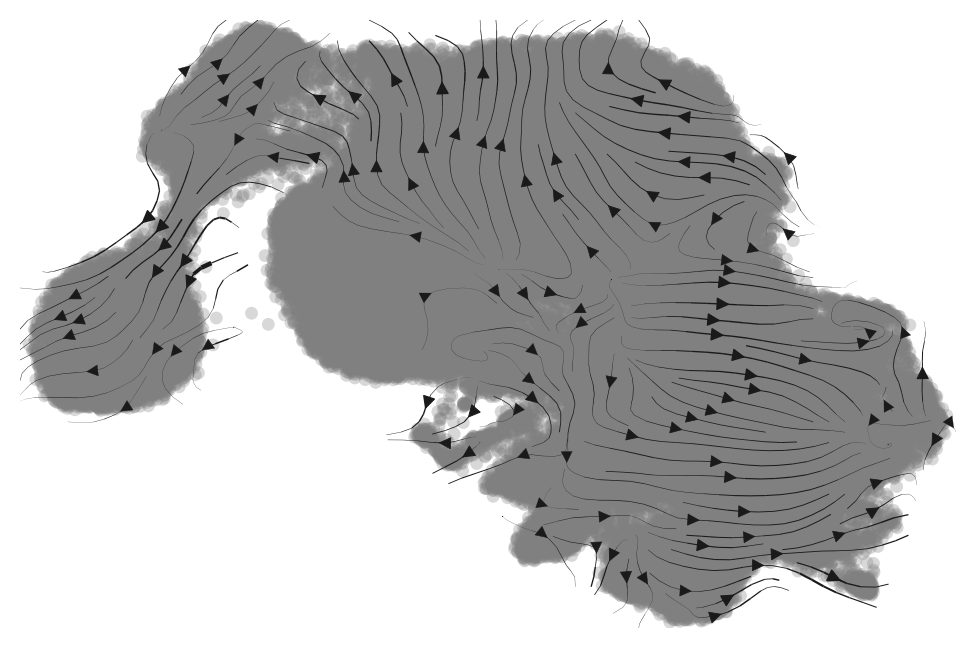

In [11]:
w_ck.transition_matrix = combined_kernel6.transition_matrix
w_ck.plot_projection(basis="umap", key_added='T_fwd_wck6')

saving figure to file ./figures/scvelo_scvelo_20230620_fibro_velo_pk_5to5_newembedding.png


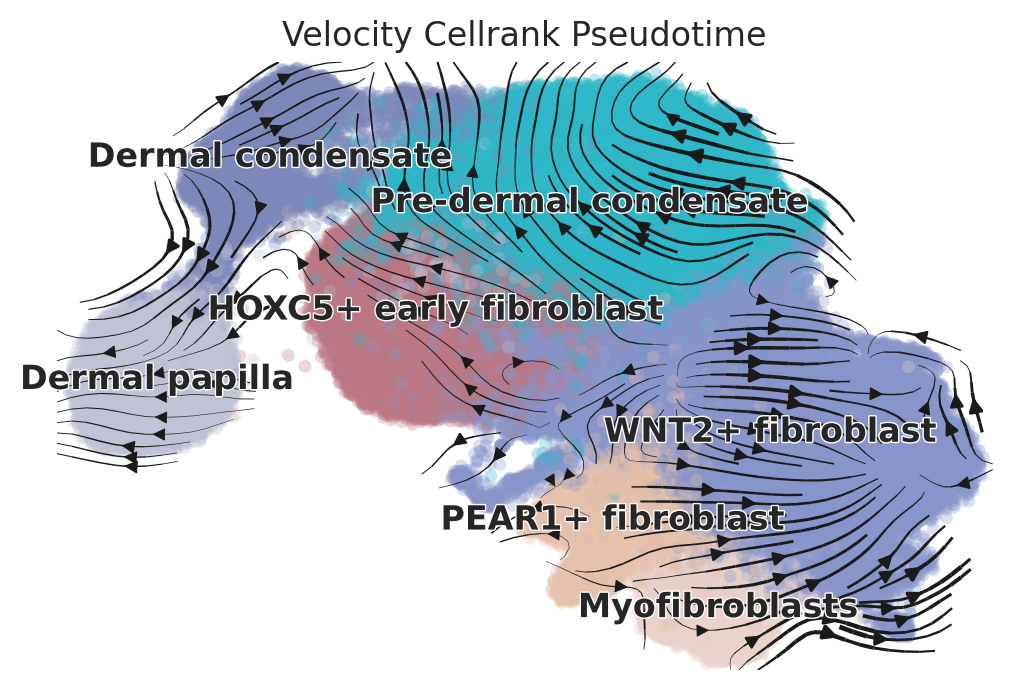

In [72]:
scv.pl.velocity_embedding_stream(adata, color=var_name,basis="umap",vkey="T_fwd_wck5", legend_fontsize=12, title="Velocity Cellrank Pseudotime", smooth=0.8, min_mass=3, save='scvelo_20230620_fibro_velo_pk_5to5_newembedding.png')

In [74]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/scvelo_fibro_final.h5ad"
adata.write(filename, compression="lzf")

# Palantir Velocity combined Kernel

GPCCA[kernel=(0.5 * VelocityKernel[n=84699] + 0.5 * PseudotimeKernel[n=84699]), initial_states=None, terminal_states=None]
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[5, 7, 11, 17, 19, 22, 24]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:27)
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[5, 7, 11]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:27)
Calculating minChi criterion in interval `[4, 13]`
Computing `4` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:13)


GPCCA[kernel=(0.5 * VelocityKernel[n=84699] + 0.5 * PseudotimeKernel[n=84699]), initial_states=None, terminal_states=None]

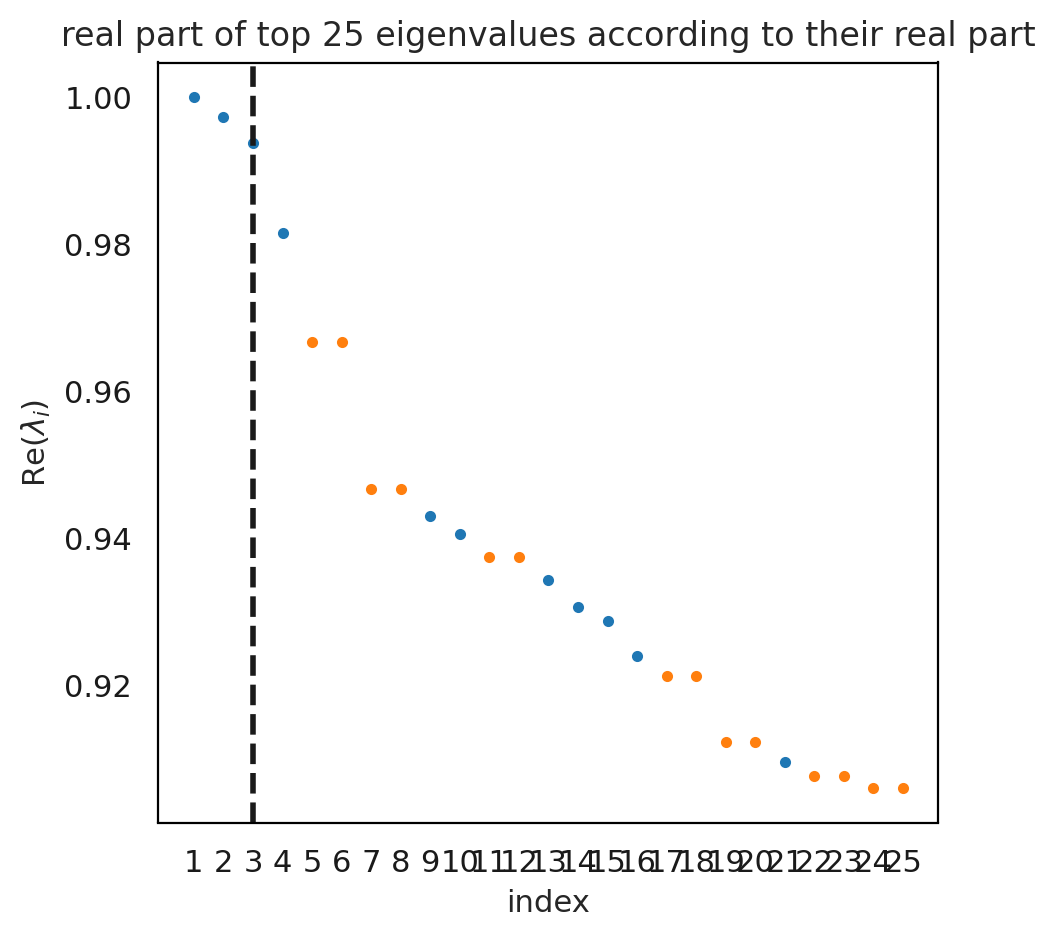

In [21]:
e = cr.estimators.GPCCA(combined_kernel5)
print(e)
e.compute_schur(n_components=25)
e.plot_spectrum(real_only=True)

e.fit(cluster_key=var_name, n_states=[4, 13])


Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:01:30)


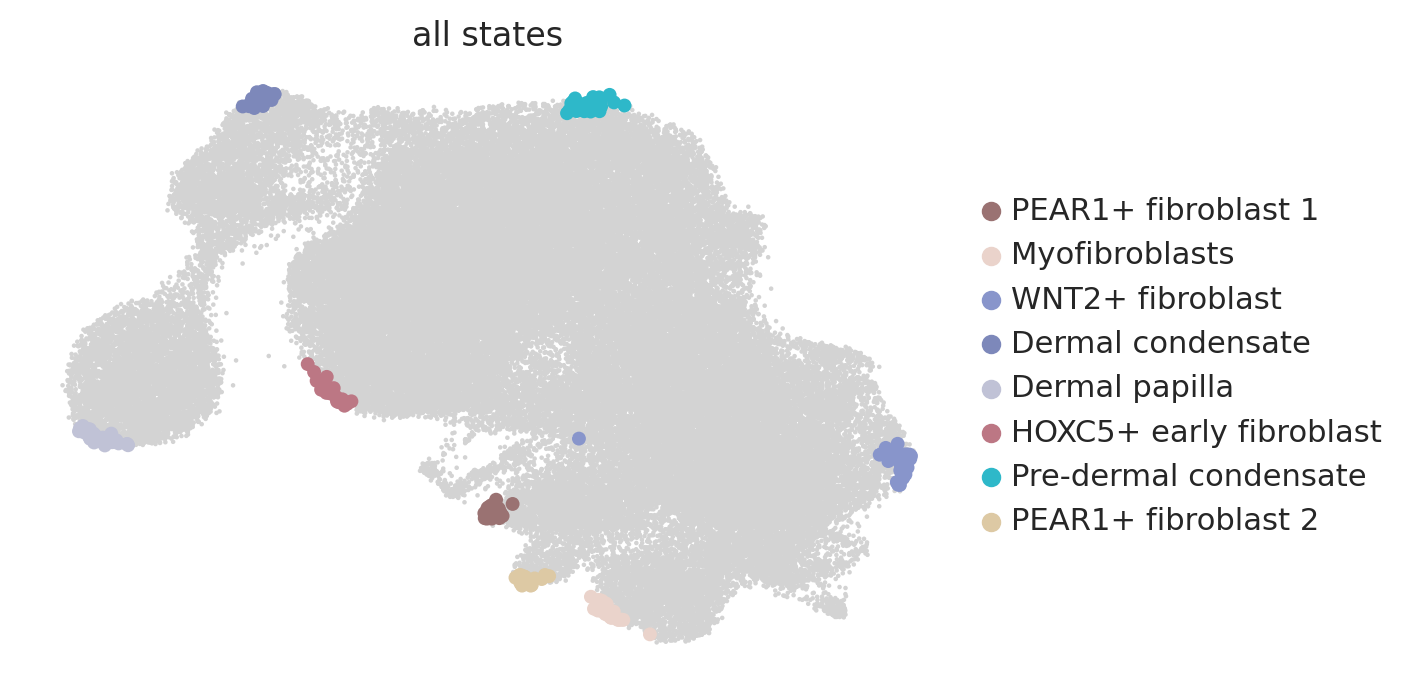

In [22]:
# Here vary a bit to best present data
e.compute_macrostates(n_states=8, cluster_key=var_name)
e.plot_macrostates(which="all", legend_loc="right", s=100)


Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


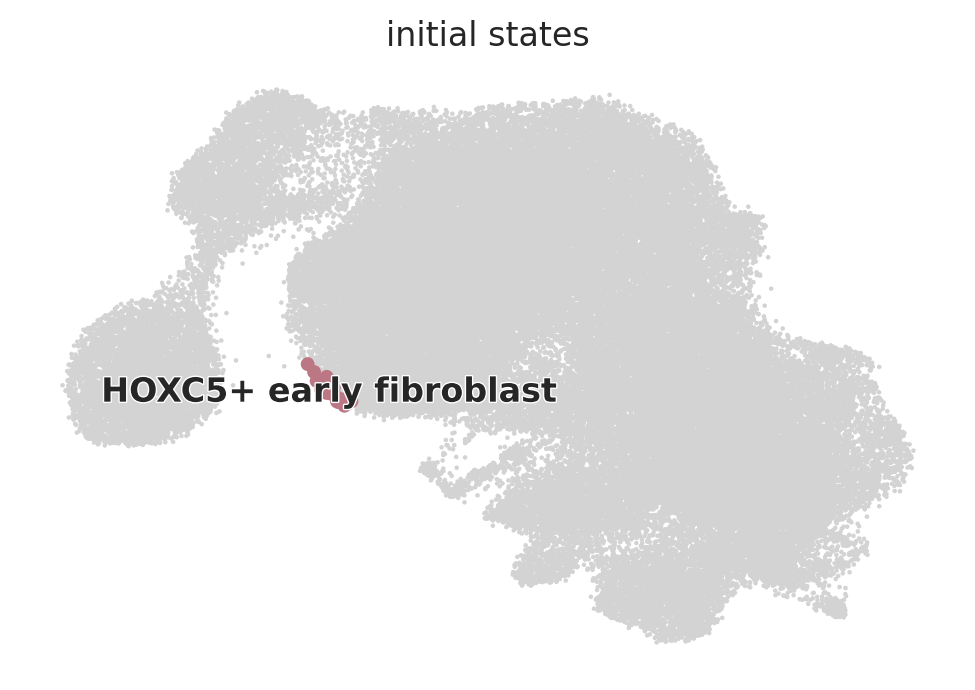

In [23]:
e.set_initial_states(states=["HOXC5+ early fibroblast"], allow_overlap=True)
e.plot_macrostates(which="initial", s=100)


Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


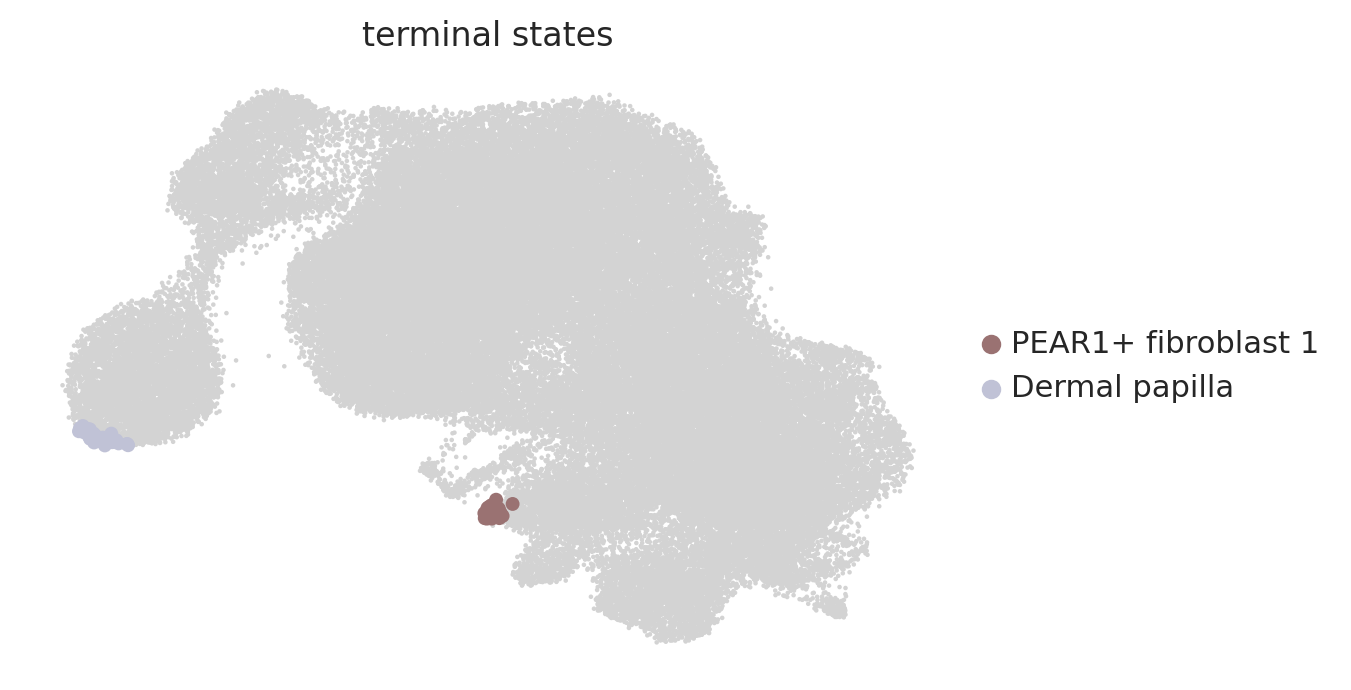

In [24]:
e.set_terminal_states(states=["PEAR1+ fibroblast_1", 'Dermal papilla'], allow_overlap=True)
e.plot_macrostates(which="terminal", legend_loc="right", s=100)


In [25]:
e.compute_fate_probabilities()
e.compute_lineage_drivers()


Computing fate probabilities


  0%|          | 0/2 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:12)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:07)


PEAR1+ fibroblast_1_corr  PEAR1+ fibroblast_1_pval  \
OGN                     0.583858                       0.0   
PLAC9                   0.579238                       0.0   
APOE                    0.503650                       0.0   
PROCR                   0.497289                       0.0   
IGFBP7                  0.487031                       0.0   
...                          ...                       ...   
TPD52                  -0.372169                       0.0   
CRABP1                 -0.388113                       0.0   
TCF4                   -0.440588                       0.0   
STMN1                  -0.454932                       0.0   
CXCL14                 -0.471178                       0.0   

        PEAR1+ fibroblast_1_qval  PEAR1+ fibroblast_1_ci_low  \
OGN                          0.0                    0.579401   
PLAC9                        0.0                    0.574745   
APOE                         0.0                    0.498606   
PROCR                        0.0                    0.492203   
IGFBP7                       0.0                    0.481877   
...                          ...                         ...   
TPD52                        0.0                   -0.377956   
CRABP1                       0.0                   -0.393819   
TCF4                         0.0                   -0.445999   
STMN1                        0.0                   -0.460256   
CXCL14                       0.0                   -0.476401   

        PEAR1+ fibroblast_1_ci_high  Dermal papilla_corr  Dermal papilla_pval  \
OGN                        0.588279            -0.583857                  0.0   
PLAC9                      0.583695            -0.579237                  0.0   
APOE                       0.508659            -0.503649                  0.0   
PROCR                      0.502341            -0.497289                  0.0   
IGFBP7                     0.492152            -0.487031                  0.0   
...                             ...                  ...                  ...   
TPD52                     -0.366353             0.372170                  0.0   
CRABP1                    -0.382378             0.388114                  0.0   
TCF4                      -0.435145             0.440591                  0.0   
STMN1                     -0.449575             0.454933                  0.0   
CXCL14                    -0.465922             0.471180                  0.0   

        Dermal papilla_qval  Dermal papilla_ci_low  Dermal papilla_ci_high  
OGN                     0.0              -0.588278               -0.579400  
PLAC9                   0.0              -0.583695               -0.574745  
APOE                    0.0              -0.508658               -0.498605  
PROCR                   0.0              -0.502341               -0.492202  
IGFBP7                  0.0              -0.492151               -0.481877  
...                     ...                    ...                     ...  
TPD52                   0.0               0.366353                0.377957  
CRABP1                  0.0               0.382379                0.393819  
TCF4                    0.0               0.435148                0.446002  
STMN1                   0.0               0.449576                0.460258  
CXCL14                  0.0               0.465924                0.476403  

[10000 rows x 10 columns]

In [ ]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/scvelo_fibro_final_palantir.h5ad"
adata.write(filename, compression="lzf")

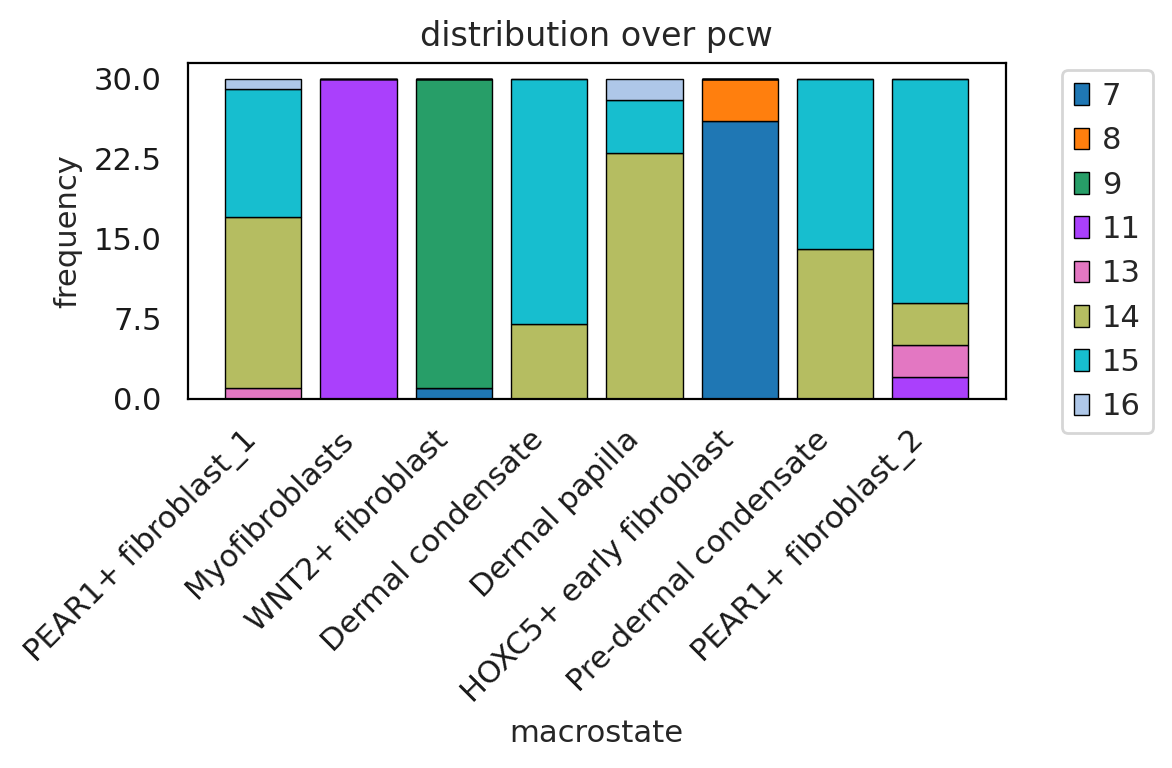

In [85]:
e.plot_macrostate_composition(key="pcw")


# Calculate psudotime for the two kernels

In [86]:

w_ck = vk.copy()
w_ck.transition_matrix = combined_kernel5.transition_matrix
w_ck.write_to_adata(key="VelocityPalantir_matrix")


In [ ]:
scv.tl.velocity_graph(adata, vkey='VelocityPalantir_matrix')
scv.tl.velocity_pseudotime(adata, vkey='VelocityPalantir_matrix')
scv.tl.latent_time(adata, vkey='VelocityPalantir_matrix', root_key='init_states_fwd_probs', end_key='term_states_fwd_probs')

computing velocities
    finished (0:06:47) --> added 
    'VelocityPalantir_matrix', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/26 cores)


/home/jovyan/my-conda-envs/clone_20230628_cellrank/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:437: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/84699 [00:00<?, ?cells/s]

    finished (0:20:10) --> added 
    'VelocityPalantir_matrix_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:43) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


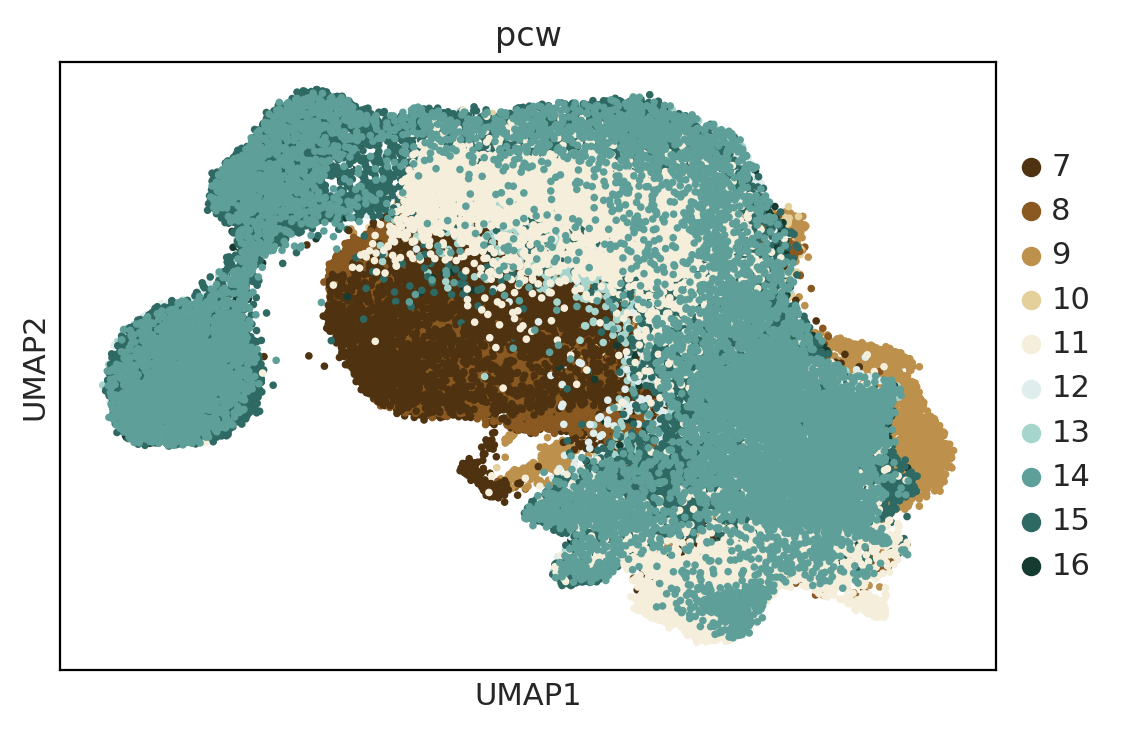

In [27]:
colors_pcw=['#4f3210', '#895921', '#bd904c', '#e3d09b', '#f4eedb', '#dfeeec', '#a5d5cd', '#5ea099', '#2e6963','#163b30']

colors = colors_pcw
adata.uns['pcw'+'_colors'] = colors
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline

sc.pl.umap(adata, color='pcw', alpha=1,size=30)

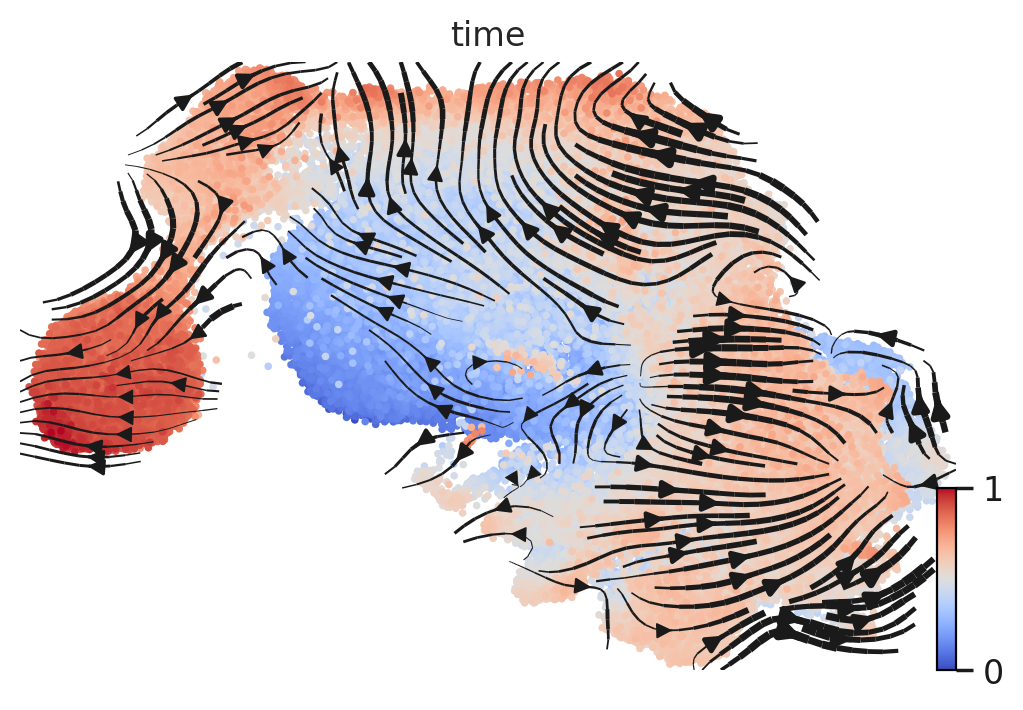

In [28]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline



scv.pl.velocity_embedding_stream(adata, color='latent_time',  
                                 color_map= 'coolwarm', basis="umap",vkey="T_fwd_wck5", legend_fontsize=12, 
                                 title="time", smooth=0.8, min_mass=3, size=30,alpha=1,arrowsize=1.2, 
                                 linewidth=2)

running PAGA using priors: ['latent_time']
    finished (0:00:23) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


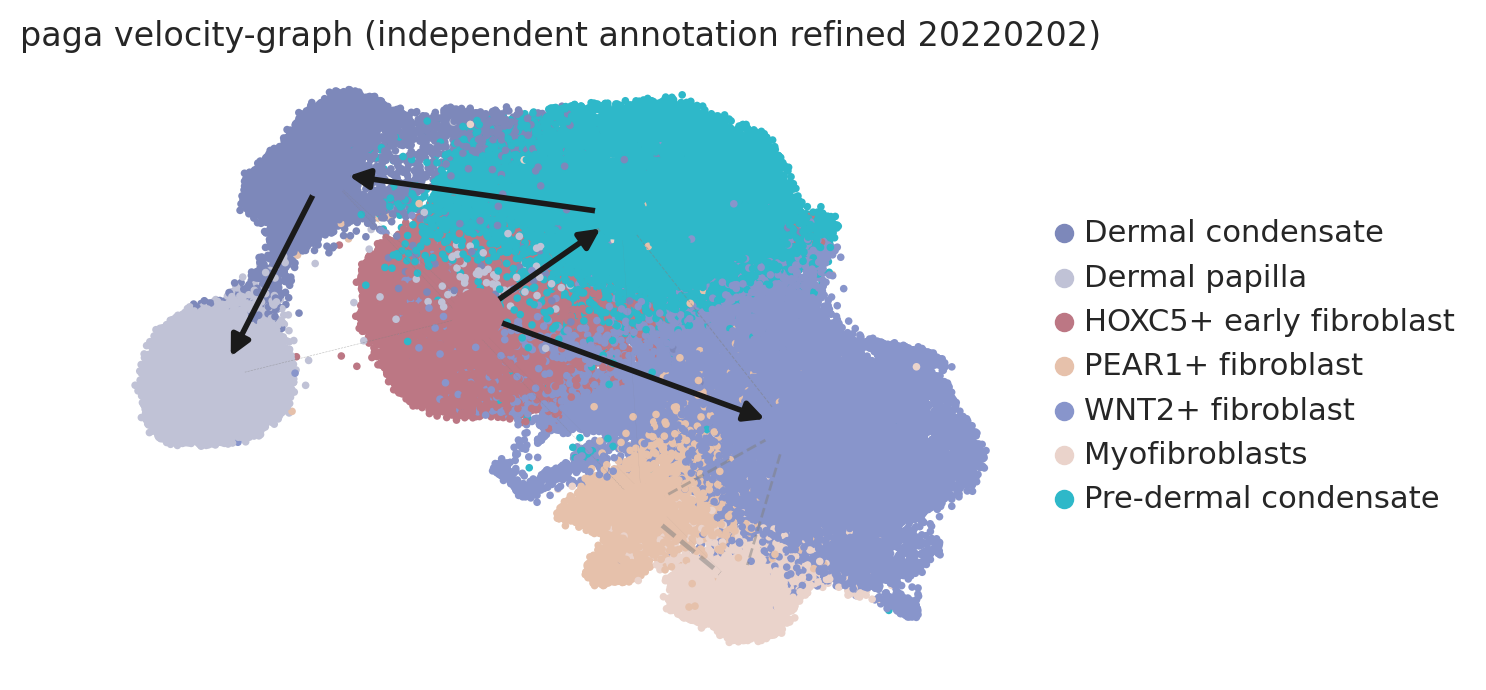

In [30]:

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline
scv.tl.paga(adata, groups=var_name, vkey='velocity', use_time_prior='latent_time');
scv.pl.paga(adata, basis='umap', color=var_name, vkey='velocity', node_size_scale=2,node_size_power=0, min_edge_width=2,
            fontsize=14, legend_loc='right margin', use_raw=False,
        size=30, alpha=1, frameon=False)


# Calculate lineage drivers for individual populations

In [31]:
first_df = e.compute_lineage_drivers(
    lineages=["PEAR1+ fibroblast_1"]
)
second_df = e.compute_lineage_drivers(
    lineages=["Dermal papilla"]
)


Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:07)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:07)


In [ ]:
# add other populations as terminal states

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


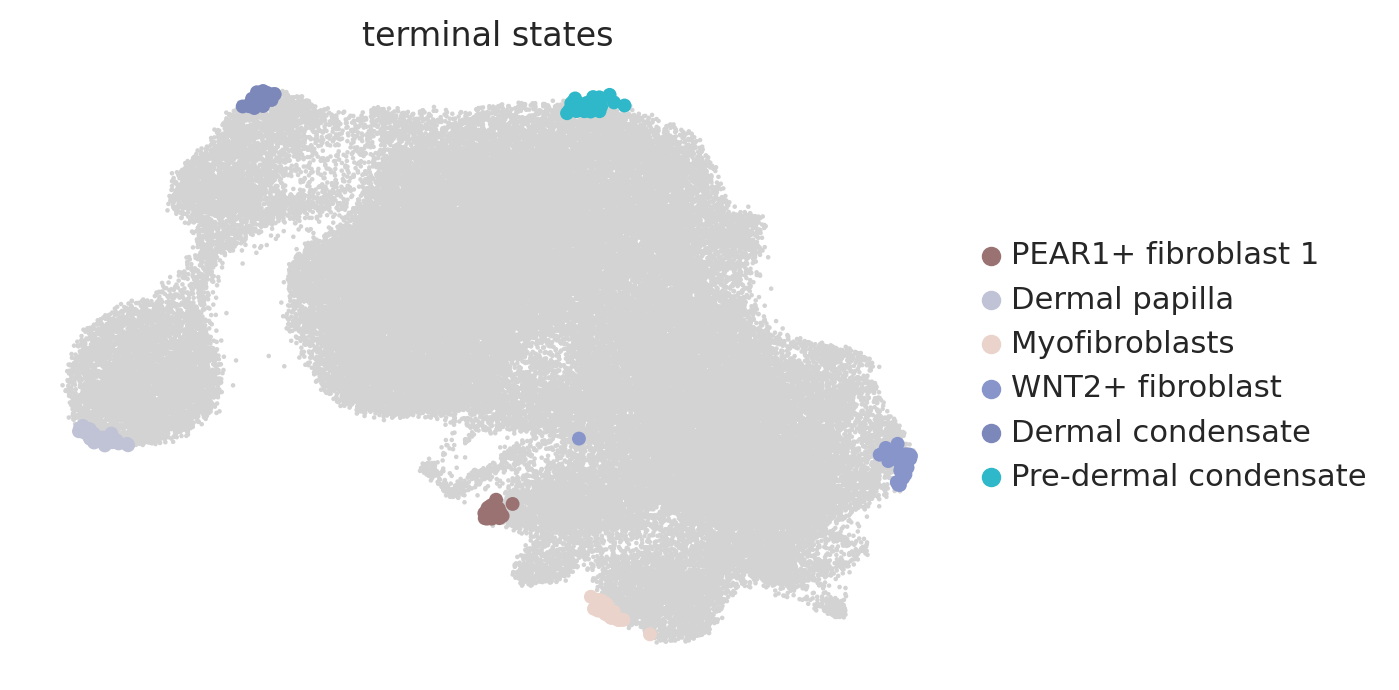

In [32]:
e.set_terminal_states(states=[ 'PEAR1+ fibroblast_1', 'Dermal papilla', 'Myofibroblasts', 'WNT2+ fibroblast', 'Dermal condensate', 'Pre-dermal condensate'], allow_overlap=True)
e.plot_macrostates(which="terminal", legend_loc="right", s=100)


In [33]:
e.compute_fate_probabilities()
e.compute_lineage_drivers()


Computing fate probabilities


  0%|          | 0/6 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:27)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:08)


PEAR1+ fibroblast_1_corr  PEAR1+ fibroblast_1_pval  \
OGN                     0.553434                       0.0   
PLAC9                   0.543181                       0.0   
APOE                    0.534831                       0.0   
IGFBP7                  0.511773                       0.0   
PROCR                   0.495531                       0.0   
...                          ...                       ...   
APCDD1                 -0.369837                       0.0   
CRABP1                 -0.378929                       0.0   
STMN1                  -0.381768                       0.0   
TCF4                   -0.449088                       0.0   
CXCL14                 -0.453334                       0.0   

        PEAR1+ fibroblast_1_qval  PEAR1+ fibroblast_1_ci_low  \
OGN                          0.0                    0.548744   
PLAC9                        0.0                    0.538416   
APOE                         0.0                    0.530006   
IGFBP7                       0.0                    0.506785   
PROCR                        0.0                    0.490433   
...                          ...                         ...   
APCDD1                       0.0                   -0.375636   
CRABP1                       0.0                   -0.384682   
STMN1                        0.0                   -0.387506   
TCF4                         0.0                   -0.454448   
CXCL14                       0.0                   -0.458669   

        PEAR1+ fibroblast_1_ci_high  Dermal papilla_corr  Dermal papilla_pval  \
OGN                        0.558088            -0.388172         0.000000e+00   
PLAC9                      0.547911            -0.415932         0.000000e+00   
APOE                       0.539622            -0.166171         0.000000e+00   
IGFBP7                     0.516726            -0.178803         0.000000e+00   
PROCR                      0.500595            -0.256011         0.000000e+00   
...                             ...                  ...                  ...   
APCDD1                    -0.364009             0.116380        9.918411e-254   
CRABP1                    -0.373146             0.214364         0.000000e+00   
STMN1                     -0.376000             0.525702         0.000000e+00   
TCF4                      -0.443695             0.166662         0.000000e+00   
CXCL14                    -0.447967             0.287249         0.000000e+00   

        Dermal papilla_qval  Dermal papilla_ci_low  Dermal papilla_ci_high  \
OGN            0.000000e+00              -0.393877               -0.382437   
PLAC9          0.000000e+00              -0.421485               -0.410346   
APOE           0.000000e+00              -0.172713               -0.159615   
IGFBP7         0.000000e+00              -0.185315               -0.172276   
PROCR          0.000000e+00              -0.262293               -0.249707   
...                     ...                    ...                     ...   
APCDD1        1.121992e-252               0.109732                0.123018   
CRABP1         0.000000e+00               0.207930                0.220780   
STMN1          0.000000e+00               0.520811                0.530558   
TCF4           0.000000e+00               0.160107                0.173202   
CXCL14         0.000000e+00               0.281058                0.293416   

        ...  Dermal condensate_corr  Dermal condensate_pval  \
OGN     ...               -0.165849            0.000000e+00   
PLAC9   ...               -0.166722            0.000000e+00   
APOE    ...               -0.148623            0.000000e+00   
IGFBP7  ...               -0.129013            0.000000e+00   
PROCR   ...               -0.136757            0.000000e+00   
...     ...                     ...                     ...   
APCDD1  ...                0.100116           7.129042e-188   
CRABP1  ...                0.158994            0.000000e+00   
STMN1   ...      

In [35]:
first_df = e.compute_lineage_drivers(
    lineages=["PEAR1+ fibroblast_1"]
)
second_df = e.compute_lineage_drivers(
    lineages=["Dermal papilla"]
)
third_df = e.compute_lineage_drivers(
    lineages=["Dermal condensate"])
fourth_df = e.compute_lineage_drivers(
    lineages=["Pre-dermal condensate"])
sixth_df = e.compute_lineage_drivers(
    lineages=["Myofibroblasts"])
seventh_df = e.compute_lineage_drivers(
    lineages=["WNT2+ fibroblast"])

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:07)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:07)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:07)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:07)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:07)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:07)
